<div align='center'>
    <img  src="https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Metallica_wordmark.svg/1280px-Metallica_wordmark.svg.png" width=500/>   
    </div>

# 🤘Visualize 'Em All🤘

This notebook is meant as a *how-to* for my Metallica Songs dataset. There are a few key techniques that you'll find handy:

- Removing duplicate albums
- Visualizing Albums & Songs by Year
- Exploring/Visualizing Song Attributes (tempo, time signature, key, etc.)
- Exploring/Visualizing Spotify Features
- Building Simple Popularity Predictor

<div align=center>
    <img src="https://wmmr.com/wp-content/uploads/sites/15/2023/03/Metallica-album-covers.jpg" width=500/>
</div>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import plotly.express as px
import plotly.graph_objects as go
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
plt.style.use('dark_background')
met_df = pd.read_csv('/kaggle/input/metallica-songs/metallica_songs.csv')

In [2]:
SPOTIFY_FEATURES = ['acousticness', 'danceability', 'energy', 'instrumentalness', 
                           'liveness', 'loudness', 'speechiness', 'valence']
MET_COLORS = ['#bd6615','#4E4D4A', '#2F343B', '#BDC3C7', '#E74C3C', '#2C3E50', 
              '#FFFF00', '#464086', '#61a2d3', '#f40502']

In [3]:
met_df.head()

,spotify_id,spotify_uri,album,name,popularity,release_date,track_number,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,3uSATa7xWXVJrMhJJSnGGk,spotify:track:3uSATa7xWXVJrMhJJSnGGk,72 Seasons,72 Seasons,71,2023-04-14,1,0.196,0.981,9,-3.865,1,0.0574,0.000042,0.0520,0.0636,0.403,168.183,459120,4
1,5iG1GycXpheJ5xMW0gNvKv,spotify:track:5iG1GycXpheJ5xMW0gNvKv,72 Seasons,Shadows Follow,70,2023-04-14,2,0.316,0.978,11,-3.937,1,0.0507,0.000106,0.0325,0.3250,0.671,178.554,371880,4
2,2hBn08QphNtdnhwDNtnZMg,spotify:track:2hBn08QphNtdnhwDNtnZMg,72 Seasons,Screaming Suicide,68,2023-04-14,3,0.427,0.973,4,-3.469,0,0.0445,0.000027,0.0200,0.2600,0.317,100.979,330453,4
3,6HeYgpgqEo8SGis4dHwRbu,spotify:track:6HeYgpgqEo8SGis4dHwRbu,72 Seasons,Sleepwalk My Life Away,68,2023-04-14,4,0.450,0.949,11,-4.181,1,0.0343,0.000021,0.0404,0.0977,0.530,124.949,416067,4
4,1ALXFmNr7lrTug2LAE989q,spotify:track:1ALXFmNr7lrTug2LAE989q,72 Seasons,You Must Burn!,67,2023-04-14,5,0.235,0.958,4,-3.069,1,0.0426,0.000090,0.0173,0.0374,0.453,172.774,423013,4


In [4]:
met_df.shape

(1487, 20)

In [5]:
met_df.columns

Index(['spotify_id', 'spotify_uri', 'album', 'name', 'popularity',
       'release_date', 'track_number', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature'],
      dtype='object')

In [6]:
met_df.dtypes

spotify_id           object
spotify_uri          object
album                object
name                 object
popularity            int64
release_date         object
track_number          int64
danceability        float64
energy              float64
key                   int64
loudness            float64
mode                  int64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
duration_ms           int64
time_signature        int64
dtype: object

# Data Cleaning

In [7]:
#Check null counts
met_df.replace('nan', np.nan, inplace=True)
nan_counts = met_df.isnull().sum()
print(nan_counts)

spotify_id          0
spotify_uri         0
album               0
name                0
popularity          0
release_date        0
track_number        0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
duration_ms         0
time_signature      0
dtype: int64


In [8]:
met_df.album.unique()

array(['72 Seasons', 'Metallica (Remastered Deluxe Box Set)',
       'Metallica (Remastered 2021)', 'S&M2',
       'Live In Brazil (1993 – 2017)', 'Live In Argentina (1993 – 2017)',
       'Live In Chile (1993 – 2017)',
       'Helping Hands…Live & Acoustic At The Masonic',
       'Helping Hands...Live & Acoustic at The Masonic',
       'ライヴ・イン・テキサス1989 (Live at リユニオン・アリーナ、ダラス、1989)',
       'Hardwired…To Self-Destruct (Deluxe)',
       'Hardwired…To Self-Destruct',
       'Metallica Through The Never (Music From The Motion Picture)',
       'Lulu', 'Six Feet Down Under', 'Six Feet Down Under Part 2',
       'Death Magnetic', 'Some Kind Of Monster',
       'Some Kind Of Monster (Live)', 'St. Anger', 'S&M', 'Garage, Inc.',
       'Garage Inc.', 'Reload', 'Load', 'Live S**t: Binge & Purge',
       'Live Sh*t: Binge & Purge (Live In Mexico City)', 'Metallica',
       'Metallica (Remastered)', '...And Justice for All (Remastered)',
       '...And Justice for All (Remastered Deluxe Box Set)

The album names have a lot of duplicates because of remasters and box sets. Lets remove those and the non-english ablum to reduce noise in the visuals.

In [9]:
# Remove remastered, deluxe, special characters
# Create masks
mask_deluxe = met_df['album'].str.contains('Deluxe / Remastered', regex=True)
mask_deluxe_rem = met_df['album'].str.contains('Deluxe Remaster', regex=True)
mask_deluxe_rem_dbs = met_df['album'].str.contains('Deluxe Box Set', regex=True)
mask_non_english = met_df['album'].apply(lambda x: bool(re.search(r'[^\x00-\x7F]+', x)))

met_df = met_df[~(mask_deluxe | mask_non_english | mask_deluxe_rem | mask_deluxe_rem_dbs)]

In [10]:
# All older metallica albums are referred to as "remastered". Remove from album titles
met_df['album'] = met_df['album'].str.replace('\\(Remastered\\)', '', regex=True)

In [11]:
# Remove anything in parentheses, punctuation, and convert to lower case
met_df['album_simplified'] = met_df['album'].str.replace(r'\(.*\)', '', regex=True)
met_df['album_simplified'] = met_df['album_simplified'].str.replace('[^\w\s]', '', regex=True)
met_df['album_simplified'] = met_df['album_simplified'].str.lower()
met_df['album_simplified'] = met_df['album_simplified'].str.strip()

#Remove duplicate albums
# Find the first song of each album
first_songs = met_df.sort_values('release_date').groupby('album_simplified').first()

# Extract the album names of these first songs
unique_albums = first_songs['album']

# Keep only the songs whose album is in the list of unique albums
met_df = met_df[met_df['album'].isin(unique_albums)]

# drop the 'album_simplified' column
met_df.drop('album_simplified', axis=1, inplace=True)

In [12]:
#Songs to seconds
met_df['duration_sec'] = met_df['duration_ms']/60.0

# Number of Songs By Year

In [13]:
met_df['release_date'] = pd.to_datetime(met_df['release_date'])
met_df['year'] = met_df['release_date'].dt.year
count_by_year = met_df.groupby('year').size()

In [14]:
# Convert 'nan' string to actual NaNs
met_df.replace('nan', np.nan, inplace=True)
nan_counts = met_df.isnull().sum()
print(nan_counts)

spotify_id          0
spotify_uri         0
album               0
name                0
popularity          0
release_date        0
track_number        0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
duration_ms         0
time_signature      0
duration_sec        0
year                0
dtype: int64


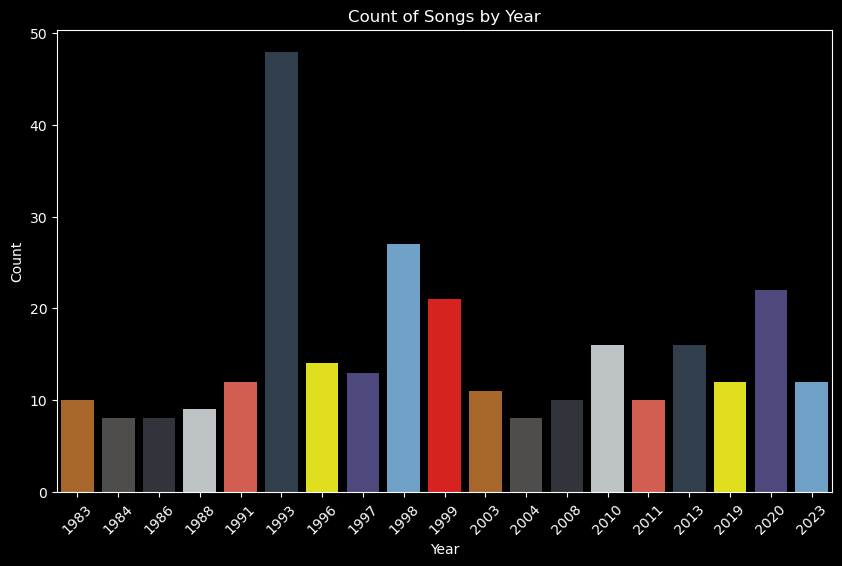

In [15]:
plt.figure(figsize=(10, 6))
sns.countplot(x='year', data=met_df, palette=MET_COLORS)
plt.title('Count of Songs by Year', color='white')
plt.xlabel('Year', color='white')
plt.ylabel('Count', color='white')
plt.xticks(rotation=45, color='white')
plt.yticks(color='white')
plt.show()

# Duration by Album

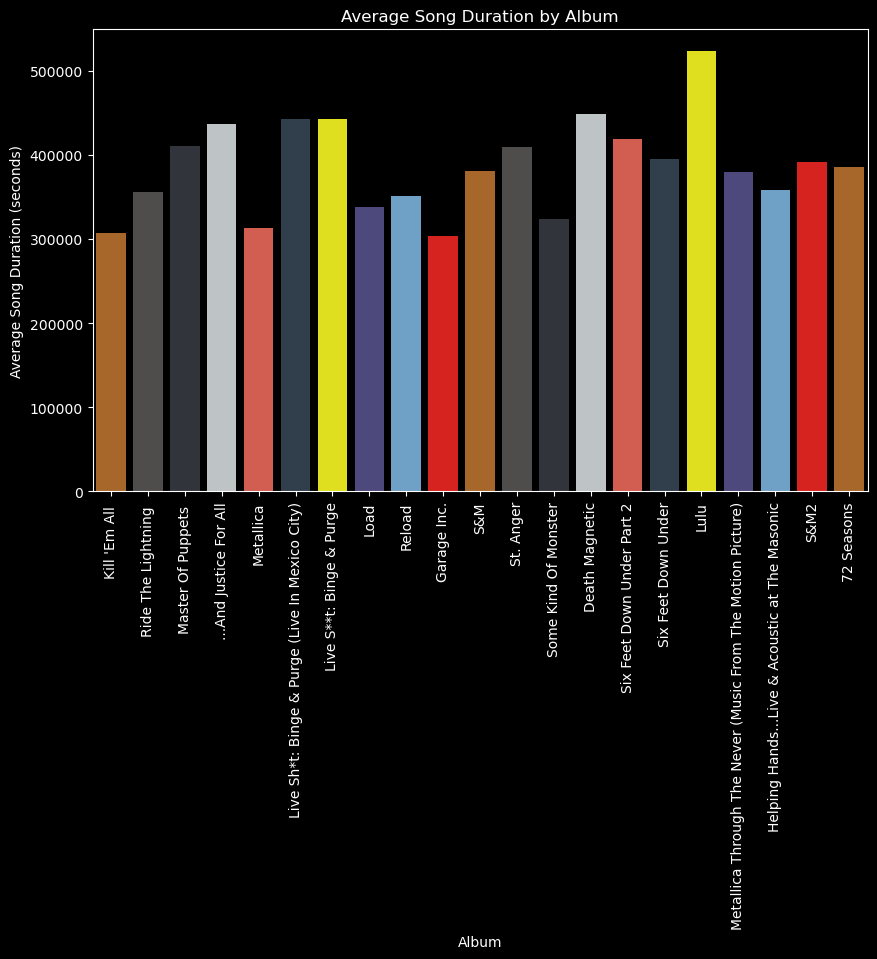

In [16]:
album_duration = met_df.groupby(['album', 'release_date'])['duration_ms'].mean().reset_index()
album_duration['release_date'] = pd.to_datetime(album_duration['release_date'])
album_duration = album_duration.sort_values(by='release_date')

plt.figure(figsize=(10, 6))
sns.barplot(x='album', y='duration_ms', data=album_duration, palette=MET_COLORS)
plt.title('Average Song Duration by Album')
plt.xlabel('Album')
plt.ylabel('Average Song Duration (seconds)')
plt.xticks(rotation=90)
plt.show()

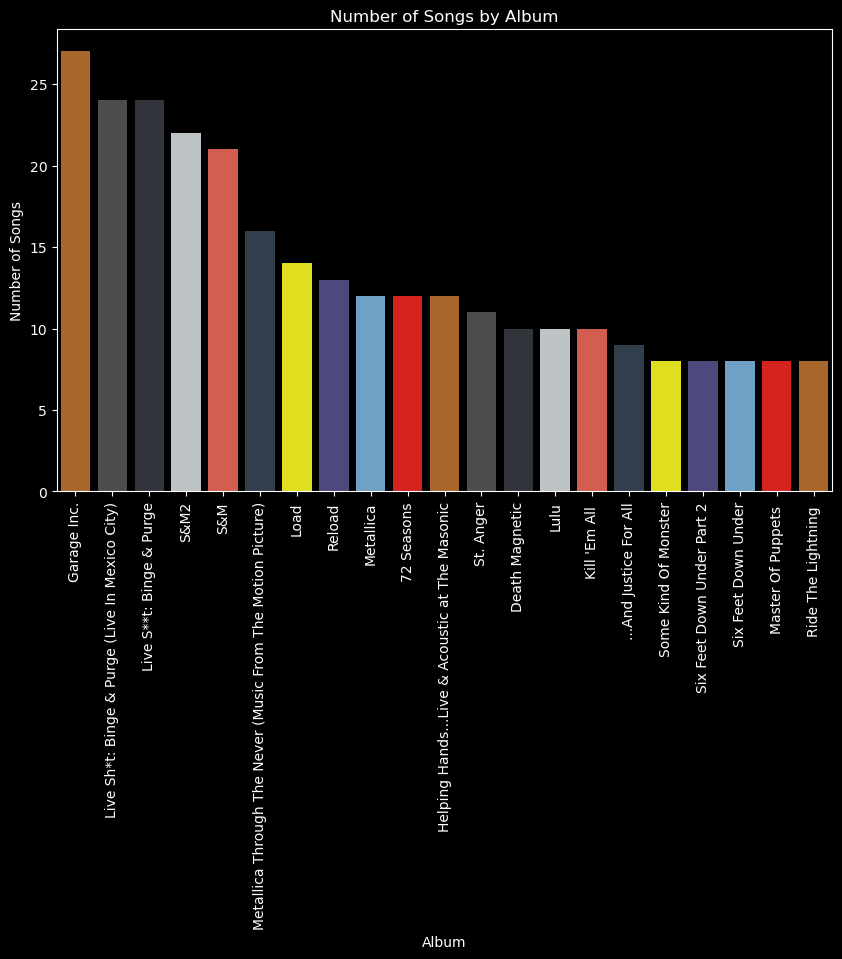

In [17]:
songs_per_album = met_df['album'].value_counts()
songs_per_album_df = songs_per_album.reset_index()
songs_per_album_df.columns = ['album', 'count']

plt.figure(figsize=(10, 6))
sns.barplot(x='album', y='count', data=songs_per_album_df, palette=MET_COLORS)
plt.title('Number of Songs by Album')
plt.xlabel('Album')
plt.ylabel('Number of Songs')
plt.xticks(rotation=90)
plt.show()

# Song Writing

## Key

Spotify creates the 'key' of a song using Pitch Class notation which is a standard mapping used in music data.

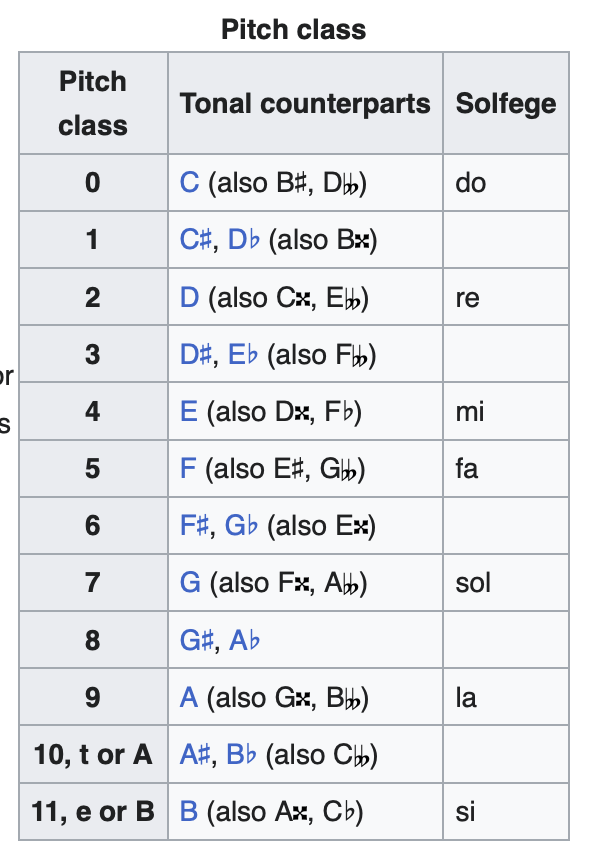



In [18]:
# Create Pitch Class Mapping
note_mapping = {0: 'C', 1: 'C#/Db', 2: 'D', 3: 'D#/Eb', 4: 'E', 5: 'F',
                6: 'F#/Gb', 7: 'G', 8: 'G#/Ab', 9: 'A', 10: 'A#/Bb', 11: 'B'}
met_df['Note'] = met_df['key'].map(note_mapping)

# Count the number of occurrences of each key
key_counts = met_df['Note'].value_counts()
top_10_keys = key_counts[:10]
top_10_keys_df = top_10_keys.reset_index()
top_10_keys_df.columns = ['Key', 'Count']

In [19]:
fig = px.bar(top_10_keys_df, x='Key', y='Count', title='Top 10 Most Common Keys of Metallica Songs',
             labels={'Count': 'Number of Songs', 'Key': 'Key'}, color='Count', color_continuous_scale='YlOrRd', template='plotly_dark')
fig.update_layout(title_font=dict(size=22, color='white'))
fig.show()

## Mode

From the Spotify API: Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0.

In [20]:
mode_counts = met_df['mode'].value_counts()
mode_df = pd.DataFrame({'Mode': ['Major', 'Minor'], 'Count': mode_counts})

# Create the pie chart
fig = go.Figure(data=[go.Pie(labels=mode_df['Mode'], values=mode_df['Count'], 
                             marker_colors=['#61a2d3','red'], textfont={'color':'white'})])

fig.update_layout(
    title_text='Major vs Minor Modes in Metallica Songs',
    title_font=dict(size=22, color='white'),
    paper_bgcolor='black',
    legend=dict(
        font=dict(
            color='white'
        )
    )
)
fig.show()

## Time Signature

In [21]:
met_df['time_signature'].value_counts()

4    267
3     20
Name: time_signature, dtype: int64

In [22]:
# Convert 'Time Signature' to string type to only show 3,4
time_signature_counts = met_df['time_signature'].value_counts()
time_signature_df = time_signature_counts.reset_index()
time_signature_df.columns = ['Time Signature', 'Count']
time_signature_df['Time Signature'] = time_signature_df['Time Signature'].astype(str)

fig = px.bar(time_signature_df, x='Time Signature', y='Count', title='Time Signatures of Metallica Songs',
             labels={'Count': 'Number of Songs', 'Time Signature': 'Time Signature'}, 
             template='plotly_dark')
fig.update_layout(title_font=dict(size=22, color='white'))
fig.update_traces(marker_color=MET_COLORS[-1])  # Set to your desired color
fig.show()

## Tempo

The Spotify API defines Tempo as:

- **tempo**: The overall tempo or speed of a track measured in beats per minute (BPM).

In [23]:
fig = px.histogram(met_df, x="tempo", nbins=50, title='Distribution of Tempo in Metallica Songs',
                   labels={'tempo': 'Tempo (BPM)'}, 
                   template='plotly_dark')
fig.update_layout(title_font=dict(size=22, color='white'))
fig.update_traces(marker_color=MET_COLORS[-1], marker_line=dict(width=1, color='white'))  # Set to your desired color
fig.show()

# Popularity Over Time

In [24]:
popularity_by_year = met_df.groupby('year')['popularity'].mean().reset_index()
fig = px.line(popularity_by_year, x="year", y="popularity", 
              title='Average Popularity Over the Years',
              labels={'popularity': 'Average Popularity', 'year': 'Year'}, 
              template='plotly_dark')

fig.update_traces(line=dict(color=MET_COLORS[-1]))
fig.update_layout(title_font=dict(size=22, color='white'))
fig.show()

# Most Popular Songs

In [25]:
# Deal with duplicate song issue
def make_unique(list_of_names):
    seen = set()
    for item in list_of_names:
        count = list_of_names.count(item)
        if count > 1:
            seen.add(item)

    for item in seen:
        i = 1
        for index, name in enumerate(list_of_names):
            if name == item:
                if i > 1:
                    list_of_names[index] = name + " " + str(i)
                i += 1

    return list_of_names

In [26]:
def plot_top_songs(column, color, n=10):
    # Get the top n songs for column
    if column == "loudness":
        top_songs = met_df.nsmallest(n, column)
    else:
        top_songs = met_df.nlargest(n, column)
    
    # Truncate song names to a certain length
    top_songs['truncated_name'] = top_songs['name'].apply(lambda x: x[:15] + '...' if len(x) > 15 else x)
    
    top_songs['truncated_name'] = make_unique(top_songs['truncated_name'].tolist())

    # Plot top n songs
    fig = px.bar(top_songs, x="truncated_name", y=column, title=f"Top {n} {column.capitalize()} Metallica Songs",
                labels={
                     column: column.capitalize(),
                     "truncated_name": "Song Title"},
                     text_auto='.2s', template = "plotly_dark")

    fig.update_layout(title_text=f'<b>Top {n} {column.capitalize()} Metallica Songs</b>', titlefont = dict(
         family = 'Arial, sans-serif',
         size = 30
      ), title_x=0.5)

    fig.update_layout(
    font=dict(
        family="Arial, sans-serif",
        size=16 
        )
    )

    fig.update_traces(marker_color=color)
    
    if column == 'loudness':
        tick_values = np.arange(-20, 0, 1)
        fig.update_yaxes(tickvals=tick_values)
        fig.update_traces(hovertemplate='Song: %{x}<br>Loudness: %{y:.2f}<extra></extra>')
    fig.show()

In [27]:
def plot_avg_by_album(color, column):
    # Calculate the average popularity for each album
    avg_popularity = met_df.groupby('album')[column].mean().sort_values(ascending=False)

    # Convert the series to a dataframe for easier plotting
    avg_popularity_df = avg_popularity.reset_index()

    # Truncate album names to a certain length
    avg_popularity_df['truncated_album'] = avg_popularity_df['album'].apply(lambda x: x[:10] + '...' if len(x) > 10 else x)

    # Make album names unique
    avg_popularity_df['truncated_album'] = make_unique(avg_popularity_df['truncated_album'].tolist())


    fig = px.bar(avg_popularity_df, x='truncated_album', y=column, title='Average Popularity by Album',
                labels={
                    column: f'Average {column.capitalize()}',
                    'truncated_album': 'Album'},
                template='plotly_dark')

    fig.update_layout(title_text=f'<b>Average {column.capitalize()} by Album</b>', titlefont=dict(
        family='Arial, sans-serif',
        size=30), title_x=0.5)

    fig.update_layout(
        font=dict(
            family="Arial, sans-serif",
            size=16  # Set the font size here
        )
    )

    fig.update_traces(marker_color=color)  # Bright yellow
    fig.show()

In [28]:
plot_top_songs('popularity', '#FFFF00', 10)

# Spotify Song Features

The Spotify dataset contains the following columns:

- **acousticness**: This measure ranges from 0.0 to 1.0. A higher value indicates a greater presence of acoustic elements (e.g., use of acoustic instruments), while a lower value indicates a greater presence of electronic elements.

- **danceability**: This measure ranges from 0.0 to 1.0. Higher values indicate a higher likelihood of the track being suitable for dancing, considering aspects like rhythm stability, tempo, beat strength, and overall regularity.

- **energy**: This measure ranges from 0.0 to 1.0. Higher values indicate a higher level of energy, implying more intense, faster, and louder tracks. Lower values indicate a more relaxed or subdued energy level.

- **instrumentalness**: This measure ranges from 0.0 to 1.0. A higher value indicates a greater presence of instrumental content, while a lower value suggests more vocal content (e.g., singing). Tracks with an instrumentalness value above 0.5 are likely to be instrumental.

- **liveness**: This measure ranges from 0.0 to 1.0. Higher values indicate a higher likelihood of the track being a live recording. A value above 0.8 provides strong likelihood that the track is live.

- **loudness**: This is a measure of the overall loudness of a track in decibels (dB), and the values typically range from -60 to 0. Loudness is a complex perception that is influenced not only by volume but also by other acoustic properties of the sound. Note that louder tracks have values closer to 0, and the 'loudness' measure is averaged across the entire track.

- **speechiness**: This measure ranges from 0.0 to 1.0. Higher values indicate a higher presence of spoken words, while lower values suggest more musical or instrumental elements. Tracks with a speechiness above 0.66 are likely entirely spoken words (e.g., talk shows, audio books, poetry), between 0.33 and 0.66 can be a mix of music and speech, such as rap music, and tracks with values below 0.33 are likely music and other non-speech-like tracks.

- **valence**: This measure ranges from 0.0 to 1.0. Higher values indicate a more positive or happier emotional character, while lower values indicate a more negative or sad emotional character.

- **popularity**: A measure of the popularity of a track. Popularity scores range from 0 to 100, with higher scores indicating greater popularity. Popularity is calculated by algorithm and is based, in the most part, on the total number of plays the track has had and how recent those plays are.


In [29]:
plot_top_songs('acousticness', '#E74C3C', 15)

In [30]:
plot_top_songs('danceability', "#2E75B6", 10)

In [31]:
plot_top_songs('energy', '#bd6615')

In [32]:
plot_top_songs('instrumentalness', '#464086')

In [33]:
plot_top_songs('liveness', '#f40502')

In [34]:
#Transform loudness so that it looks appropriate on a chart
met_df['loudness'] = met_df['loudness'].round(1)*-1.0

In [35]:
plot_top_songs('loudness', '#FFFF00')

Apparently Death Magnetic is the "loudest" album overall? Really?

In [36]:
met_df['loudness'] = met_df['loudness'].round(1)*-1.0
plot_avg_by_album('#FFFF00', 'loudness')

Fascinating, I always feel like Death Magnetic feels more muted but apparently not to a computer!

In [37]:
plot_top_songs('speechiness', '#883825')

In [38]:
plot_top_songs('tempo', '#61a2d3')

In [39]:
plot_top_songs('valence', '#FFFFFF')

In [40]:
spotify_features = met_df[['acousticness', 'danceability', 'energy', 'instrumentalness', 
                           'liveness', 'loudness', 'speechiness', 'valence']]

fig = px.scatter_matrix(spotify_features, width=1200, height=1200)
fig.update_traces(diagonal_visible=False)
fig.update_layout(title_text='Spotify Feature Interaction')
fig.show()

# Predicting Popularity

I'm curious to see which song features are more predictive, and if its even possible to build a decent model on top of this small dataset. An important aspect to keep in mind is that 'popularity' is somewhat of a moving target. 72 Seasons is their newest album and appropriately their most popular on Spotify as of right now. I'm not an expert on how this score is updated but I would imagine that popularity can be somewhat depreciated over time. Although it somehow still shows Enter Sandman as the most popular song, which must be true and might indicate that depreciation isn't much of an issue.

In [41]:
met_df.columns

Index(['spotify_id', 'spotify_uri', 'album', 'name', 'popularity',
       'release_date', 'track_number', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature',
       'duration_sec', 'year', 'Note'],
      dtype='object')

In [42]:
# Correlation Heatmap
cols = ['popularity',
       'release_date', 'track_number', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature']

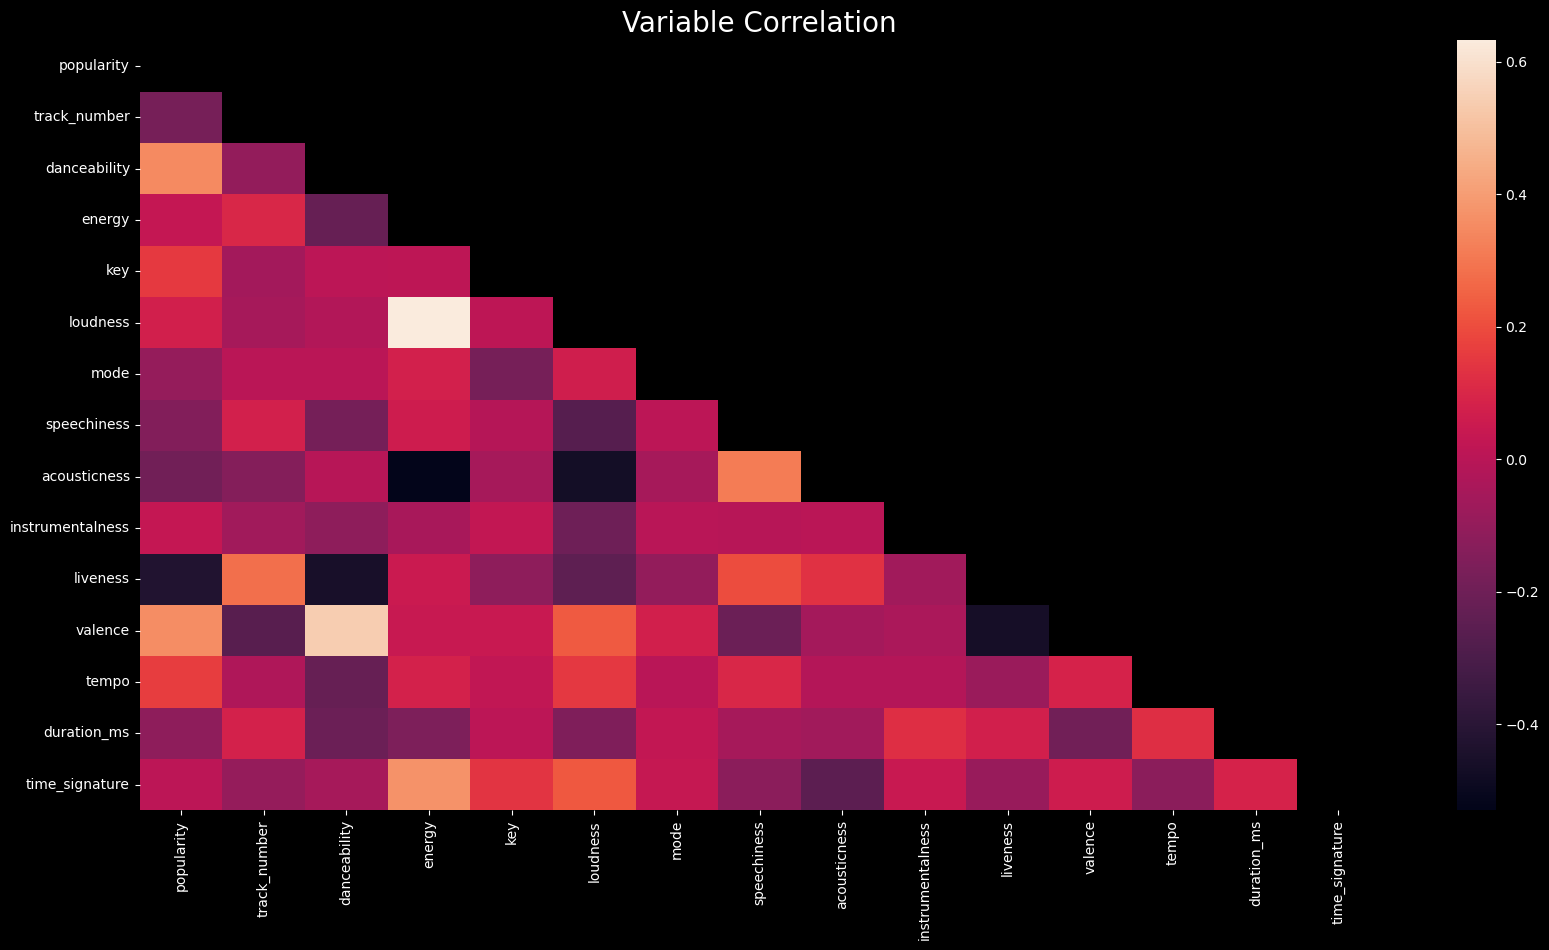

In [43]:
plt.figure(figsize=(20,10))
mask = np.triu(np.ones_like(met_df[cols].corr()))
sns.heatmap(met_df[cols].corr(),annot=False,mask=mask)
plt.title('Variable Correlation', fontsize=20) 
plt.show()

In [44]:
met_df.shape

(287, 23)

In [45]:
#Album Encoders
met_df.reset_index(drop=True, inplace=True)

# Use one-hot encoding for the album names
encoder = OneHotEncoder(sparse=False)
album_encoded = encoder.fit_transform(met_df[['album']])

# Transform it into a dataframe
album_encoded_df = pd.DataFrame(album_encoded, columns=encoder.get_feature_names_out(['album']))

# Concatenate the new columns to the original dataframe
met_df = pd.concat([met_df, album_encoded_df], axis=1)

In [46]:
#Drop columns we don't want as features
X = met_df.drop(['popularity', 'name', 'release_date', 'album', 'spotify_id', 'spotify_uri', 'track_number', 'Note'], axis=1)
#Create target variable
y = met_df['popularity']

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [48]:
model = xgb.XGBRegressor(objective ='reg:squarederror')
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [49]:
#Testing error
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse}")

RMSE: 8.973059583536408


In [50]:
#Training Error
y_pred = model.predict(X_train)
rmse = np.sqrt(mean_squared_error(y_train, y_pred))
print(f"RMSE: {rmse}")

RMSE: 0.0019977744875009085


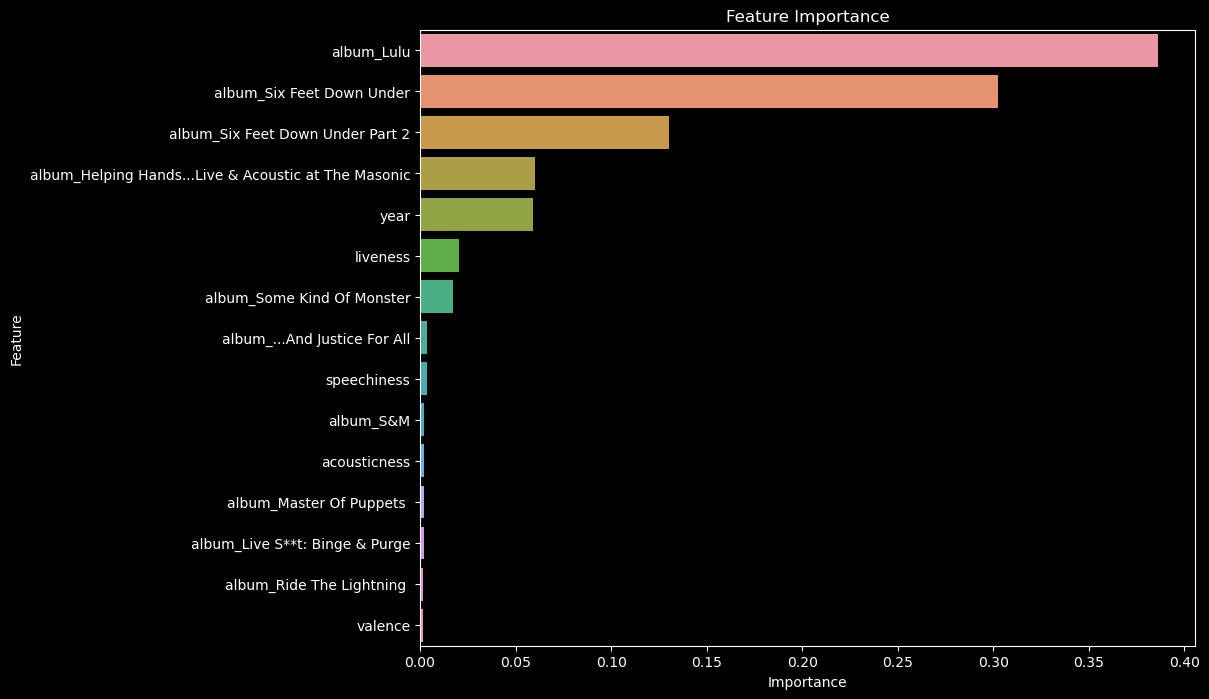

In [51]:
# Get feature importance
importance = model.feature_importances_

# Create a dataframe for feature importances
importance_df = pd.DataFrame({"Feature": X.columns, "Importance": importance})

# Sort the dataframe by importance in descending order and take the top 15
importance_df = importance_df.sort_values("Importance", ascending=False).head(15)

# Plot feature importance
plt.figure(figsize=(10, 8))
sns.barplot(data=importance_df, x="Importance", y="Feature")
plt.title('Feature Importance')
plt.show()

This is actually pretty funny. The most predictive features are indicators of their 3 least popular albums on Spotify. This can be seen by looking at average popularity by album.

# Look At Popularity By Album

In [52]:
plot_avg_by_album('#FFFF00', 'popularity')

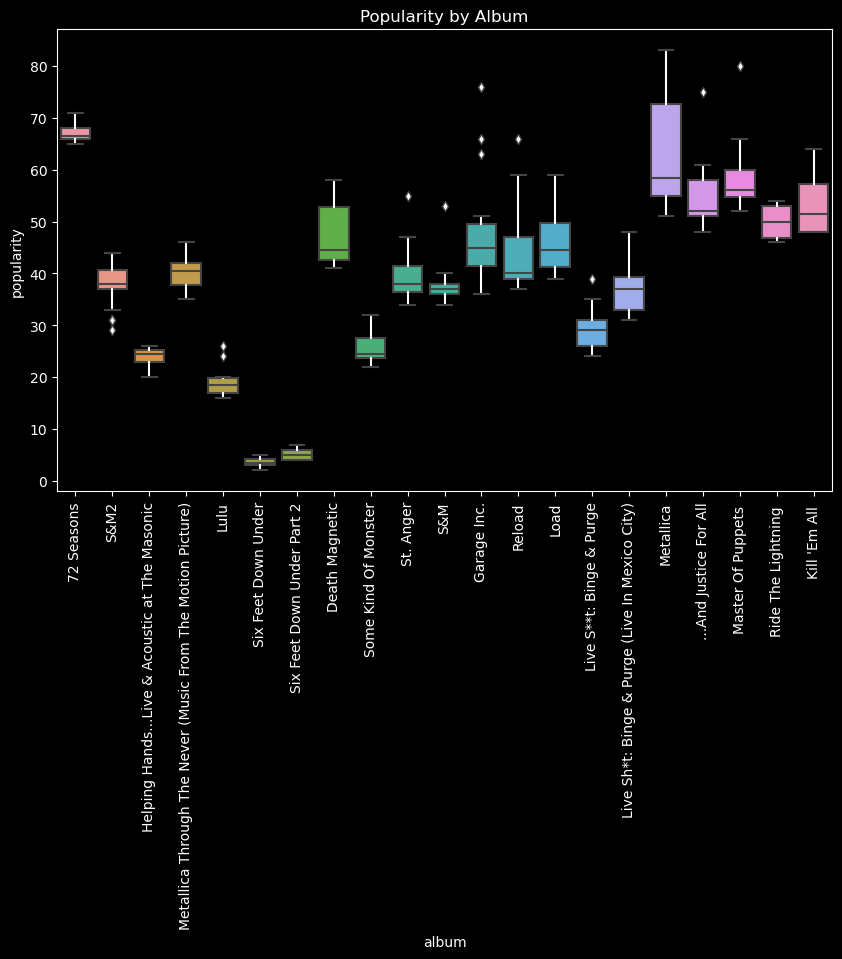

In [53]:
plt.figure(figsize=(10,6))
sns.boxplot(x='album', y='popularity', data=met_df,
            whiskerprops=dict(color="white"), # This changes the color of the whiskers
            flierprops=dict(markerfacecolor='white')) # This changes the color of the outliers
plt.xticks(rotation=90)
plt.title('Popularity by Album')
plt.show()

# Model Upgrade, Remove Most Unpopular Albums

In [54]:
drop_albums = ['Lulu', 'Six Feet Down Under', 'Six Feet Down Under Part 2']
mask = met_df['album'].isin(drop_albums)
met_df = met_df[~mask]

In [55]:
X = met_df.drop(['popularity', 'name', 'release_date', 'album', 'spotify_id', 'spotify_uri', 'track_number', 'Note'], axis=1)
y = met_df['popularity']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = xgb.XGBRegressor(objective ='reg:squarederror')
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [56]:
#Testing Error
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse}")

RMSE: 10.165754269923646


In [57]:
#Training Error
y_pred = model.predict(X_train)
rmse = np.sqrt(mean_squared_error(y_train, y_pred))
print(f"RMSE: {rmse}")

RMSE: 0.001790234043077998


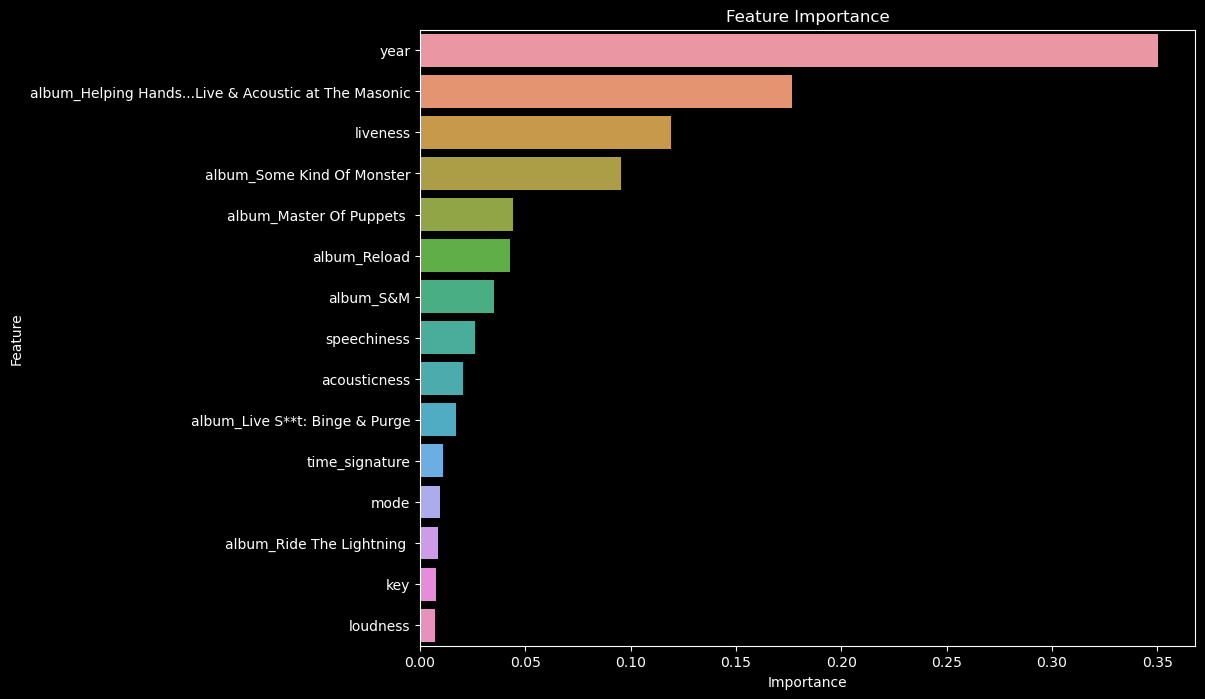

In [58]:
#Updated Feature Importance
importance = model.feature_importances_
importance_df = pd.DataFrame({"Feature": X.columns, "Importance": importance})
importance_df = importance_df.sort_values("Importance", ascending=False).head(15)

plt.figure(figsize=(10, 8))
sns.barplot(data=importance_df, x="Importance", y="Feature")
plt.title('Feature Importance')
plt.show()

The 'year' variable being the most influential makes sense because popularity also takes into account how recent the streams took place.

# Model Upgrade: Just Spotify Features

In [59]:
X = met_df[SPOTIFY_FEATURES]
y = met_df['popularity']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = xgb.XGBRegressor(objective ='reg:squarederror')
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [60]:
#Testing Error
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse}")

RMSE: 12.88168352996338


In [61]:
#Training Error
y_pred = model.predict(X_train)
rmse = np.sqrt(mean_squared_error(y_train, y_pred))
print(f"RMSE: {rmse}")

RMSE: 1.2528820791706123


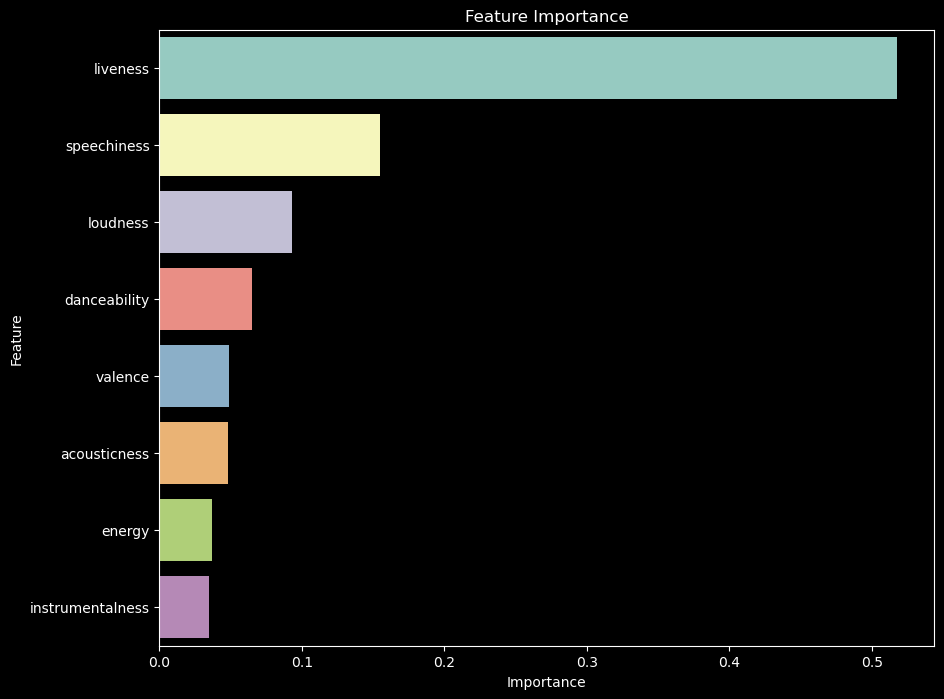

In [62]:
importance = model.feature_importances_
importance_df = pd.DataFrame({"Feature": X.columns, "Importance": importance})
importance_df = importance_df.sort_values("Importance", ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(data=importance_df, x="Importance", y="Feature")
plt.title('Feature Importance')
plt.show()

The third model doesn't seem to improve much in terms of the relationship between training/testing error. The model is overfitting by about the same amount. But 'liveness' seems to be the most important predictor of popularity overall when compared to the rest of the spotify features. But overall a pretty noisy dataset. I'm sure if we had access to the number of streams that would be much more predictive.

## Exit Light

**We've hit the lights on Metallica's Spotify data, now you see how I pulled the strings in order to visualize em' all in action. I hope you enjoyed this journey twisting, turning, *through the never*.**



<div align=center>
    <img src="https://townsquare.media/site/366/files/2023/05/attachment-amsterdamlivemetallica.jpg?w=980&q=75" width=500/>
</div>

# Sourced From [Spotify Web API](https://developer.spotify.com/documentation/web-api/)




<div align=center>
    <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/84/Spotify_icon.svg/1982px-Spotify_icon.svg.png" width=100/>
</div>

# Other Helpful Links

[Metallica Songs Kaggle Dataset](https://www.kaggle.com/datasets/jonbown/metallica-songs)

[Data GitHub Repo](https://github.com/jon-bown/metallica)